In [1]:
## Loads the Libraries

import pandas as pd
from transformers import AutoTokenizer
from typing import Dict
from sklearn.model_selection import train_test_split
import pyarrow as pa
from datasets import Dataset
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import datetime
import torch
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

## Train model

In [2]:
## Define finction to process data
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
def process_data(row) -> Dict:
    
    text = row['Policy']
    text = str(text)
    text = ' '.join(x.lower() for x in text.split())
    
    # encodings = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    encodings = tokenizer(text)
    
    label = 1
    
    if row['Classification'] == 'Positive': label = 0

    encodings['label'] = label
    encodings['text'] = text

    return encodings

In [3]:

## Load data and perform train - test - validation split
df = pd.read_excel("Final_Data.xlsx")

processed_data = []
for i in range(len(df)):
    processed_data.append(process_data(df.iloc[i]))


new_df = pd.DataFrame(processed_data)
train_df, valid_df = train_test_split(
    new_df,
    test_size=0.2,
    random_state=42
)

train_hg = Dataset(pa.Table.from_pandas(train_df))
valid_hg = Dataset(pa.Table.from_pandas(valid_df))


In [2]:
## Train the ML Model
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)

training_args = TrainingArguments(output_dir="./result", evaluation_strategy="epoch", num_train_epochs = 10, metric_for_best_model="f1")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hg,
    eval_dataset=valid_hg,
    tokenizer=tokenizer
)

trainer.train()


KeyboardInterrupt



In [11]:
## Save the ML Model
today = datetime.datetime.today().strftime("%d_%m_%Y")
model_name = "./pretrained_model_" + today + "_5/"
model.save_pretrained(model_name)

## Test the model

In [4]:
today = datetime.datetime.today().strftime("%d_%m_%Y")
model_name = "./pretrained_model_" + today + "10/"
new_model = AutoModelForSequenceClassification.from_pretrained("Pretrained_Model_Best")
new_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

trainer = Trainer(
    model=new_model,
    tokenizer=new_tokenizer
)

## Define prediction function
def get_prediction(text):
    encoding = new_tokenizer(text, return_tensors="pt") ## Try removing return tensors
    encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

    outputs = new_model(**encoding)

    logits = outputs.logits

    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().cpu())
    probs = probs.detach().numpy()
    label = np.argmax(probs, axis=-1)
    
    if label == 1:
        return {
            'Classification': 'Negative',
            'probability': probs[1]
        }
    else:
        return {
            'Classification': 'Positive',
            'probability': probs[0]
        }

C:\Users\raj\AppData\Local\Temp\ipykernel_19192\2673001377.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


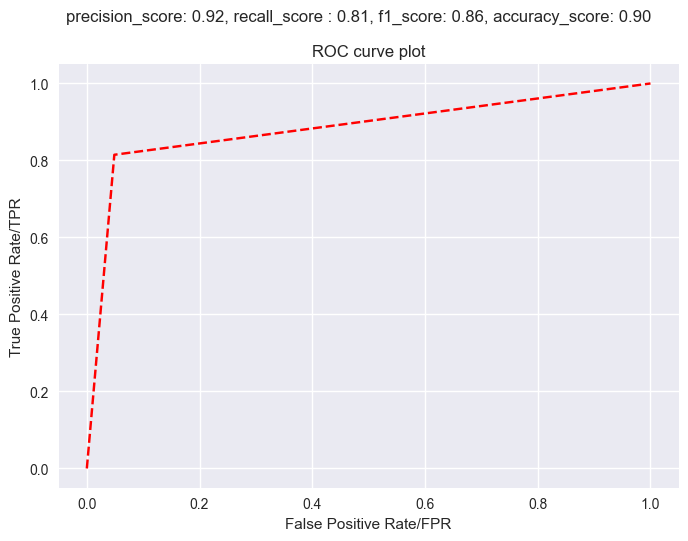

In [5]:

valid_df['pred'] = valid_df['text'].apply(lambda x : get_prediction(x)['Classification'])
valid_df['pred'] = valid_df['pred'].map({
    'Positive' : 0
    , 'Negative' : 1
})

## Calculate evaluation metrics
fpr, tpr, threshold = roc_curve(valid_df['label'], valid_df['pred'])
auc_scr = roc_auc_score(valid_df['label'], valid_df['pred'])
recall_scr = recall_score(valid_df['label'], valid_df['pred'])
accuracy_scr = accuracy_score(valid_df['label'], valid_df['pred'])
precision_scr = precision_score(valid_df['label'], valid_df['pred'])
f1_scr = f1_score(valid_df['label'], valid_df['pred'])

## Plot and save the evaluation
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='red')
plt.title('ROC curve plot')
plt.suptitle(f"precision_score: {precision_scr:.2f}, recall_score : {recall_scr:.2f}, f1_score: {f1_scr:.2f}, accuracy_score: {accuracy_scr:.2f}")
plt.xlabel('False Positive Rate/FPR')
plt.ylabel('True Positive Rate/TPR')
plt.savefig("result/" + today + ".jpg")
plt.show()

##------------------------------------------------------------------------------------------------------------------------------------